<h1> Berlin Traffic</h1>

<h4> Authors: Johnny Núñez, Iñaki Erregue </h4>
<h5>Complex Networks - Master on Fundamentals of Data science</h5>
<h6>2022-04-29</h6>

In [1]:
from IPython.display import HTML
from IPython.display import SVG
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import random
import math
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
import collections
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.animation as animation
from sknetwork.visualization import svg_graph, svg_digraph
from IPython.display import SVG

%matplotlib inline

# 0 - The Network

Source: *Transportation Networks for Research Core Team. Transportation Networks for Research. https://github.com/bstabler/TransportationNetworks.* 

The network discussed in this project represents the traffic flow between intersections in Berlin, more specifically the neighbourhood of Friedrichshain. It has a total of 523 edges and 224 nodes. Each node depicts an intersection, whereas links characterize the traffic flow itself. The graph representing the network is unwighted but directed. 

As one can see in the table below, the network contains some metadata associated to each link regarding its capacity, length, free flow time, speed limit and whereas it has a toll or not. The main objective of this network is studying the Traffic Assignment Problem, which is one of the most basic problems in transportation research. It is the process of distributing zone-to-zone trips on links of the network. The discussed network has 23 zones.

The link travel time can be computed as:  link_travel_time = free_flow_time * (1 + B * (flow/capacity)^power)

The generalized cost associated with a link can be computed as:  link_generalized_cost = link_travel_time + toll_factor * toll + distance_factor * distance.

### Loading the network

In [3]:
# Importing the networks into a Pandas dataframe consists of a single line of code
# but we can also make sure all headers are lower case and without trailing spaces
netfile = './friedrichshain-center_net.tntp'

net = pd.read_csv(netfile, skiprows=8, sep='\t')

trimmed = [s.strip().lower() for s in net.columns]
net.columns = trimmed

# And drop the silly first andlast columns
net.drop(['~', ';'], axis=1, inplace=True)

In [4]:
net.head()

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type
0,1,31,999999.0,0.0,0.0,0.0,4.0,0.0,0.0,0
1,1,32,999999.0,0.0,0.0,0.0,4.0,0.0,0.0,0
2,1,159,999999.0,0.0,0.0,0.0,4.0,0.0,0.0,0
3,1,161,999999.0,0.0,0.0,0.0,4.0,0.0,0.0,0
4,2,31,999999.0,0.0,0.0,0.0,4.0,0.0,0.0,0


In [5]:
# Compute nodes and links, what about zones? clustering?
num_links = net.shape[0]
num_nodes = len(set(list(net.init_node.unique())+list(net.term_node.unique())))
print(f'Number of nodes: {num_nodes}\nNumber of links: {num_links}')

Number of nodes: 224
Number of links: 523


In [6]:
# Compute length of the set of the different attributes composing the network
{column: len(net[column].unique()) for column in net.columns}

{'init_node': 218,
 'term_node': 222,
 'capacity': 5,
 'length': 204,
 'free_flow_time': 63,
 'b': 2,
 'power': 1,
 'speed': 1,
 'toll': 1,
 'link_type': 2}

In [7]:
# Compute set of those attributes with low length
metadata_uniques = {(column if len(net[column].unique())<=20 else None) : (list(net[column].unique()) if len(net[column].unique())<=20 else None) for column in net.columns}
metadata_uniques.pop(None)
metadata_uniques

{'capacity': [999999.0, 900.0, 2800.0, 600.0, 2400.0],
 'b': [0.0, 1.0],
 'power': [4.0],
 'speed': [0.0],
 'toll': [0.0],
 'link_type': [0, 1]}

### Loading the coordinates

In [8]:
netcoords = './friedrichshain-center_node.tntp'
nodes_mapper = './friedrichshain-center_Node-Conversion.txt'

coords = pd.read_csv(netcoords, sep='\t', index_col=False)
nodes_mapper = pd.read_csv(nodes_mapper, sep='\t', index_col=False)

trimmed = [s.strip().lower() for s in coords.columns]
coords.columns = trimmed

coords['y']=coords[';']
coords.drop(columns=';', inplace=True)

# Perform mapping
coords['node'] = nodes_mapper[' Original node number ']

# Convert pandas with forma node, x, y in a dictionary with node as key and x, y as values
coords_dict = {node+1: np.array((coords.loc[node]['x'], coords.loc[node]['y'])) for node in coords.index}

/var/folders/2c/gnzzbzv56sxdqjpm4jd2152m0000gn/T/ipykernel_8899/401558111.py:4: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  coords = pd.read_csv(netcoords, sep='\t', index_col=False)


### Visualizing the network

In [9]:
# Instantiate graph in NetworkX

G = nx.from_pandas_edgelist(net, 'init_node', 'term_node', edge_attr=True, create_using=nx.DiGraph())

In [10]:
def plot_gragh(G, scores=None, use_colors=True, cmap=plt.cm.rainbow, pos=coords_dict, node_color=None, hist=True):
    """
    Function that plots a Graph G, if node scores are pased, applies a cmap and also plots a histogram of the scores. 
    """
    
    fig = plt.figure(figsize=(16, 10), constrained_layout=True)
    ax = fig.gca()
    plt.axis('off')
    
    if pos is None:
        pos = nx.spring_layout(G, seed=0, iterations=100)


    if scores is not None:
        spec = GridSpec(ncols=2, nrows=1, width_ratios=[2, 1], height_ratios=[1], figure=fig)
        ax = plt.subplot(spec[0, 0])
        
        nodelist = sorted(G.nodes(), key=lambda n: scores[n])
        ncolor = np.asarray([scores[n] for n in nodelist])
        nx.draw_networkx_edges(G,pos=pos, width=0.5, alpha=0.7)
        nodes = nx.draw_networkx_nodes(G, nodelist=nodelist, pos=pos, node_size=100, cmap=cmap, node_color=ncolor, alpha=0.7) #vmin=0, vmax=10
        plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal', )
        
        if hist:
            plt.subplot(spec[0, 1])
            score_array = np.array(list(scores.values()))
            plt.hist(score_array, bins=100)
    
    else:
        nx.draw_networkx_edges(G,pos=pos, width=0.5, alpha=0.7)
        if node_color: 
            nx.draw_networkx_nodes(G, pos=pos, node_color=node_color, node_size=100)
        else:
            nx.draw_networkx_nodes(G, pos=pos, node_size=100, node_color='black')
    
    plt.show(block=False)


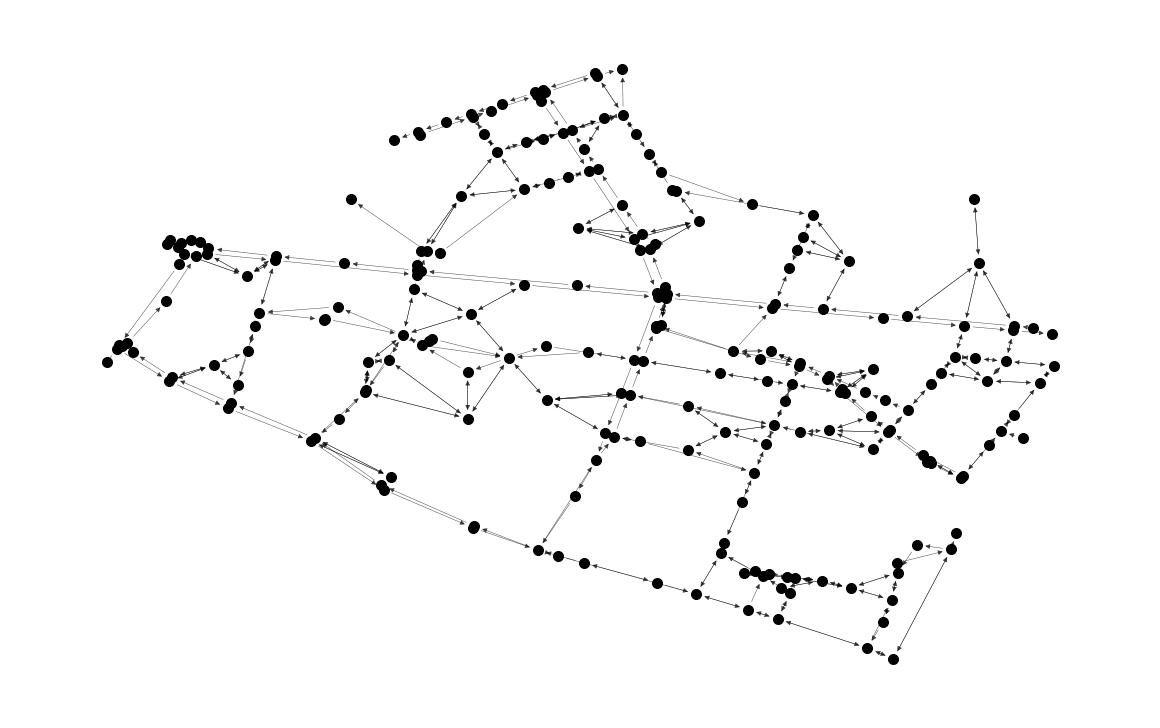

In [11]:
# Visualization of our network

plot_gragh(G, scores=None, use_colors=False)

## 0.1 - Adjacency Matrix

A network can be represented as a graph, an entity $G(N,A)$ consisting of a finite set of nodes ($N$) and a finite set of links ($A$) which connects pairs of nodes. The adjacency matrix $A$ is a square matrix used to represent a finite graph. If there are $n$ nodes in the network, $A$ has size ${n\times n}$.
$$
A_{i,j} = \begin{cases}
1 \quad\text{if there is a link from node}\,i\,\text{to node }j\newline
0 \quad\text{otherwise}
\end{cases}
$$
If the graph is undirected, the adjacency matrix is symmetric $A^T = A$.



In [12]:
adj_nx = nx.adjacency_matrix(G).toarray()
adj_nx.shape
adj_nx

/var/folders/2c/gnzzbzv56sxdqjpm4jd2152m0000gn/T/ipykernel_8899/1526500145.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_nx = nx.adjacency_matrix(G).toarray()


(224, 224)

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

# 1 - Microscale

## 1.2 - Node degree

The degree of a node $c$ ($k_c$) is the number of links connected to the given node. In directed networks we can define in-degree ($k^{in}_c$) and out-degree ($k^{out}_c$) . A source node is a node with $k^{in}=0$. On the contrary, sink node has $k^{out}=0$. If a graph $G$ has $n$ nodes, the node degree can be computed in the following way:


Undirected: $k_i = \sum^n_{j=1} A_{ij}\, ,$ 

Directed: $
\begin{cases} 
k^{in}_i = \sum^n_{j=1} A_{ji}\quad(\text{sum along column }i \text{ of } A)\, , \newline
k^{out}_i= \sum^n_{j=1} A_{ji}\quad(\text{sum along row }i \text{ of } A)\, .
\end{cases}$

In [13]:
def node_degree_out(adj_matrix):
    return np.sum(adj_matrix, axis=1)

def node_degree_in(adj_matrix):
    return np.sum(adj_matrix, axis=0)

In [14]:
k_out = node_degree_out(adj_nx)
k_in = node_degree_in(adj_nx)

# Properties satisfied!!
sum(k_out) == sum(k_in) == num_links
sum(k_in + k_out) == 2*num_links

num_sources = len(k_in) - np.count_nonzero(k_in)
num_sinks = len(k_out) - np.count_nonzero(k_out)

print(f'Number of sources: {num_sources}\nNumber of sinks: {num_sinks}')

True

True

Number of sources: 2
Number of sinks: 6


In [15]:
def nodes_by_grade(grade):
    """
    Function that returns a dictionary with the degree of the node and how many of them have it.

    :param grade: vector that returns the grau_node function.
    :return : dictionary mentioned 
    """
    unique, counts = np.unique(grade, return_counts=True)
    print(dict(zip(unique, counts)))
    return dict(zip(unique, counts))

In [16]:
in_degree_dic = nodes_by_grade(node_degree_in(adj_nx))
out_degree_dic = nodes_by_grade(node_degree_out(adj_nx))

{0: 2, 1: 61, 2: 71, 3: 46, 4: 40, 5: 2, 6: 2}
{0: 6, 1: 56, 2: 68, 3: 51, 4: 38, 5: 4, 6: 1}


In [17]:
def plot_grades(degree_hist, mode):
    plt.figure(figsize=(10,5))
    sns.barplot(y = 'degree', x = 'Number of Nodes', 
                data = degree_hist, 
                color = 'darkblue')
    plt.title(f'Number of {mode}-connections by degree')
    plt.xlabel(f'Node {mode}-Degree', fontsize=15)
    plt.ylabel('Number of Nodes', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()

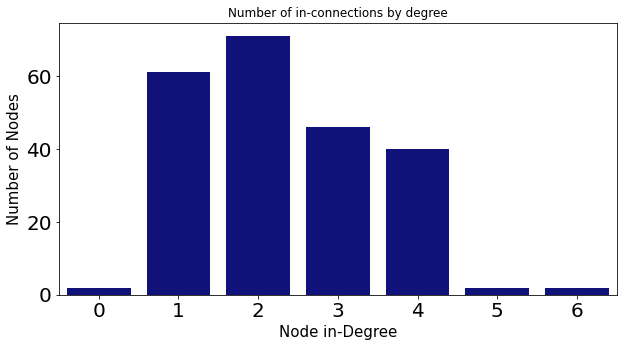

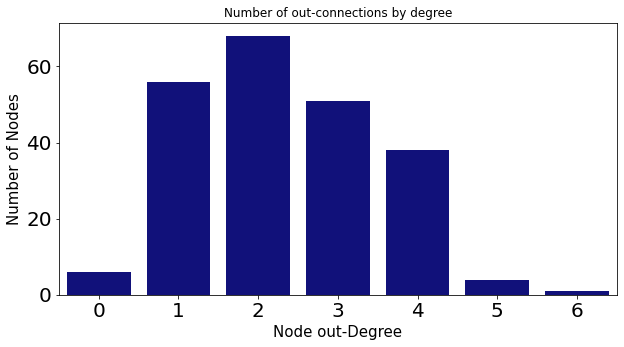

In [18]:
in_degree_hist = pd.DataFrame({"degree": list(in_degree_dic.values()), "Number of Nodes": list(in_degree_dic.keys())})
out_degree_hist = pd.DataFrame({"degree": list(out_degree_dic.values()), "Number of Nodes": list(out_degree_dic.keys())})

plot_grades(in_degree_hist, 'in')
plot_grades(out_degree_hist, 'out')

## 1.2 - Characteristic Road Length and Diameter

The average distance in a given graph with $n$ nodes represents the average number of edges that need to be traversed from one node to another node in the network. It is computed as the average of the length of the shortest path for all possible pairs of nodes in the graph (assuming the length is zero they are not reachable). If $d(u,v)$ is the shortest path between nodes $u$ and $v$, then the average distance is computed as follows:

$$
d_{avg} = \frac{1}{n(n-1)}\sum_{\forall u, v| u\neq v} d(u,v)\, .
$$

In [19]:
nx.average_shortest_path_length(G)

10.066003363228699

The network diameter is defined as the maximum distance between any pair of nodes
in the given graph. From the out-degree histogram above, we can appreciate that there is a sink in the network. Thus the graph is weakly connected, meaning that it is not possible to reach any node starting from any other node by traversing edges in the directions in which they point, but yes when the direction is ignored.

In [20]:
nx.is_strongly_connected(G)
nx.is_weakly_connected(G)

False

True

Nonetheless, the diameter can be computed by explicitly using the maximum distance of a list containing the shortest paths between any two nodes in the graph (computed with Dijkstra's algorithm), regardless of what component they may belong to. Technically, diameter is infinite for non-strongly connected digraphs which is why NetworkX's built-in method does not work. The method explained above will find the largest diameter amongst all components within G, but is not the diameter of G itself. 

In [21]:
diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
diameter

26

## 1.3 - Centrality measurements

### 1.3.1 - Degree centrality

The degree centrality of a node is the simplest of the measures and is calculated as the number of neighbors it has among the total number of nodes in the graph.

$$
C_D(u) = \frac{k_u}{(n-1)}
$$

Taking into account that nodes represent intersecctions, nodes with highest $C_D$ can be thought as those interseccions that comunicate directly with the biggest amount of intersections. In some sense, interseccions where a hugh number of streets converge, like roundabouts. The most degree central node corresponds to ?? on the left of the map.

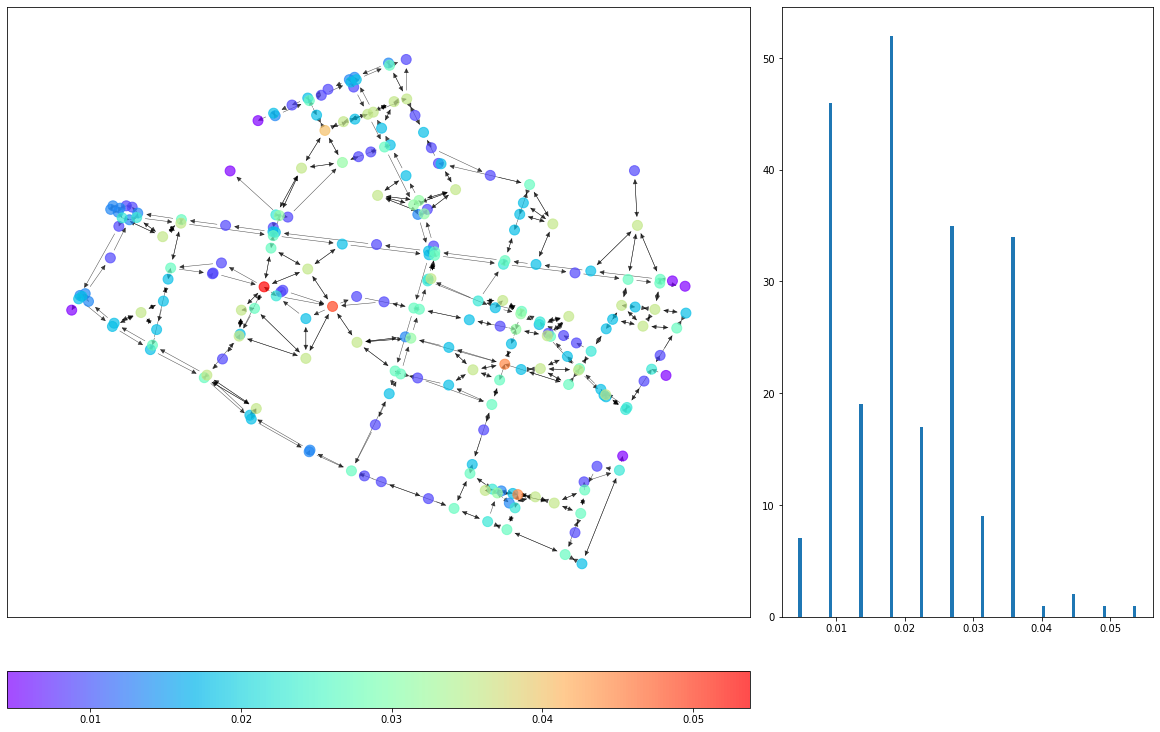

In [22]:
degree_c = nx.degree_centrality(G)
plot_gragh(G, degree_c)

### 1.3.2 - Closeness centrality

Represents the closeness of a given node with every other node of the network. Nodes with a high closeness score have the shortest distances to all other nodes. It is a way of detecting nodes that are able to spread information very efficiently through a graph.

$$
C_C(u)=\frac{n-1}{\sum_{\forall v|v\neq u}d(u,v)}\,
$$

Nodes with high $C_C$ represent those intersections that can spread the traffic flow very easly. For an optimal traffic flow these should also have associated a similar betweennes. In our case the most closness central nodes can be find aligned in the Warschauer street, showing that this road has great potential to spread the incoming traffic into the neighborhood.

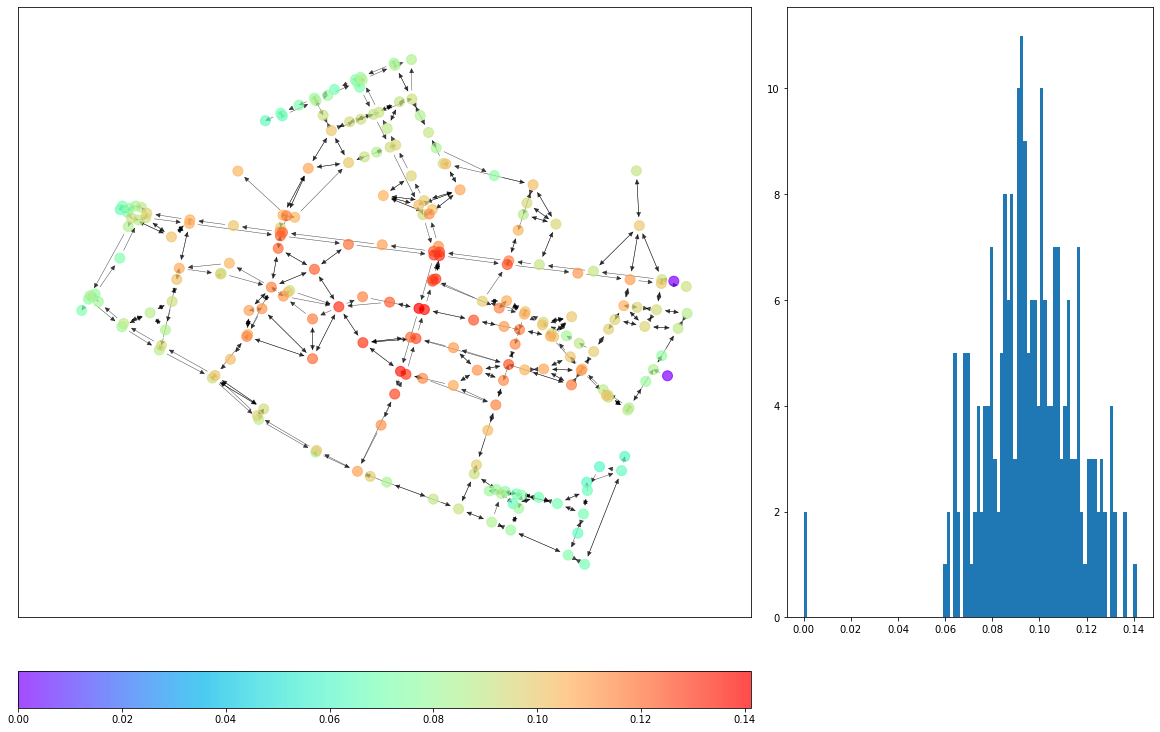

In [23]:
closeness_c = nx.closeness_centrality(G)
plot_gragh(G, closeness_c)

### 1.3.3 - Betweenness centrality

Betweenness centrality is a way of detecting the amount of influence a node has over the flow of information in a graph. Betweenness of a node arises from the fact that the relationship between two non-adjacent nodes can depend on a third, especially if it is in the path of the first two. As a result, existing nodes in the junction paths, among others, can exert a significant influence and strategic control over the rest.

As it can be seen in the plot below, red nodes are the intersections that channel more flow. In the Friedrichshain neighbourhood, the node with highest centrality corresponds to the intersection of the two most important roads, Warschauer street and Frankfurter Allee, the so-called Frankfurter Tor square.


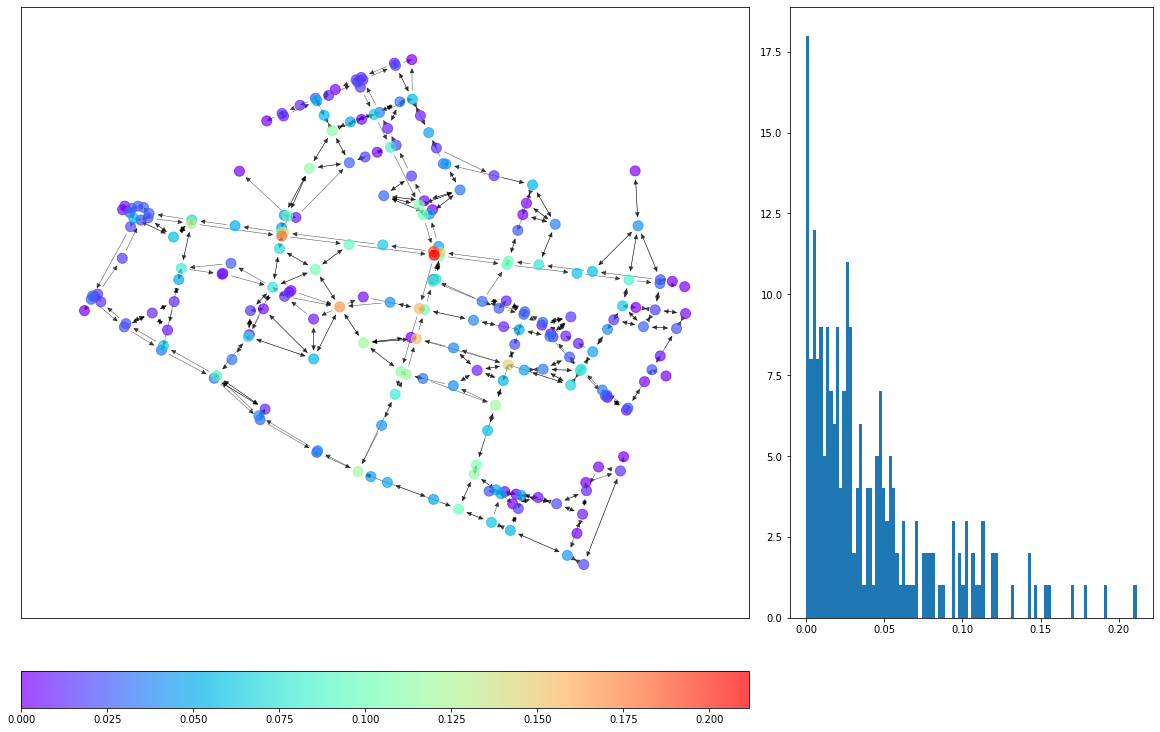

In [24]:
betweenness_c = nx.betweenness_centrality(G, weight='dist')
plot_gragh(G, betweenness_c)

### 1.3.4 - Eigenvector centrality

Eigenvector Centrality is an algorithm that measures the transitive influence of nodes. Relationships originating from high-scoring nodes contribute more to the score of a node than connections from low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores. In this case, top eigen and degree centralities coincide, assigning ?? as one of the most important intersections.

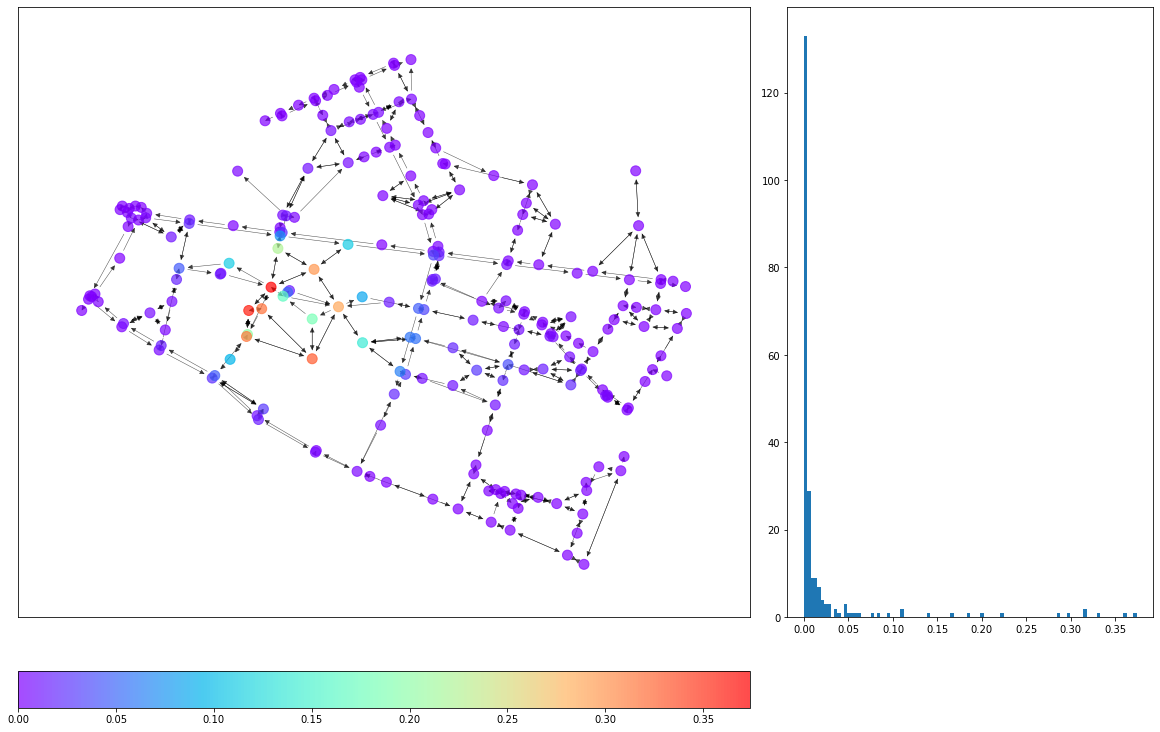

In [25]:
eigen_c = nx.eigenvector_centrality(G,max_iter=300)
plot_gragh(G, eigen_c)

### 1.3.5 PageRank

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links. It was originally designed as an algorithm to rank web pages. It measures the importance of one node based on the importance of its neighbors.

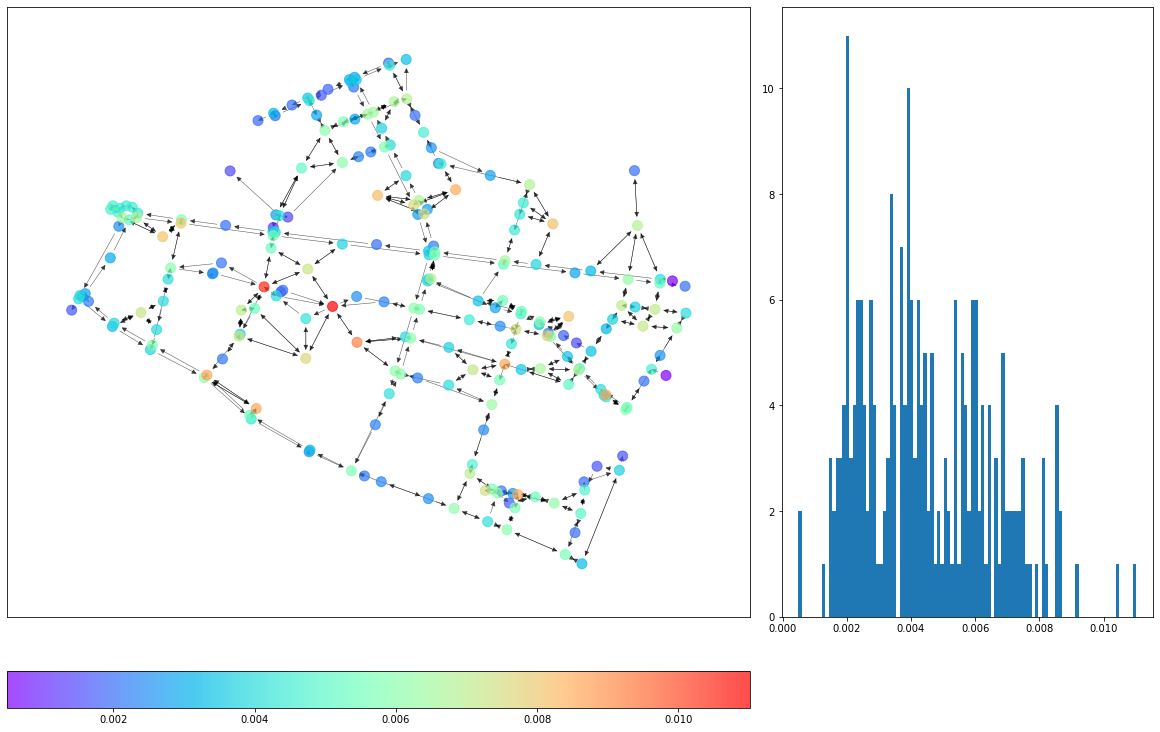

In [26]:
page_rank = nx.pagerank(G, alpha=0.9)
plot_gragh(G, page_rank)

### 1.3.6 - Katz centrality

It computes the relative influence of a node within a network by measuring the number of the immediate neighbors (first degree nodes) and also all other nodes in the network that connect to the node under consideration through these immediate neighbors. It assigns different weights to shortest paths according to their lengths, as the shorter paths are more important for information flow than the longer paths.

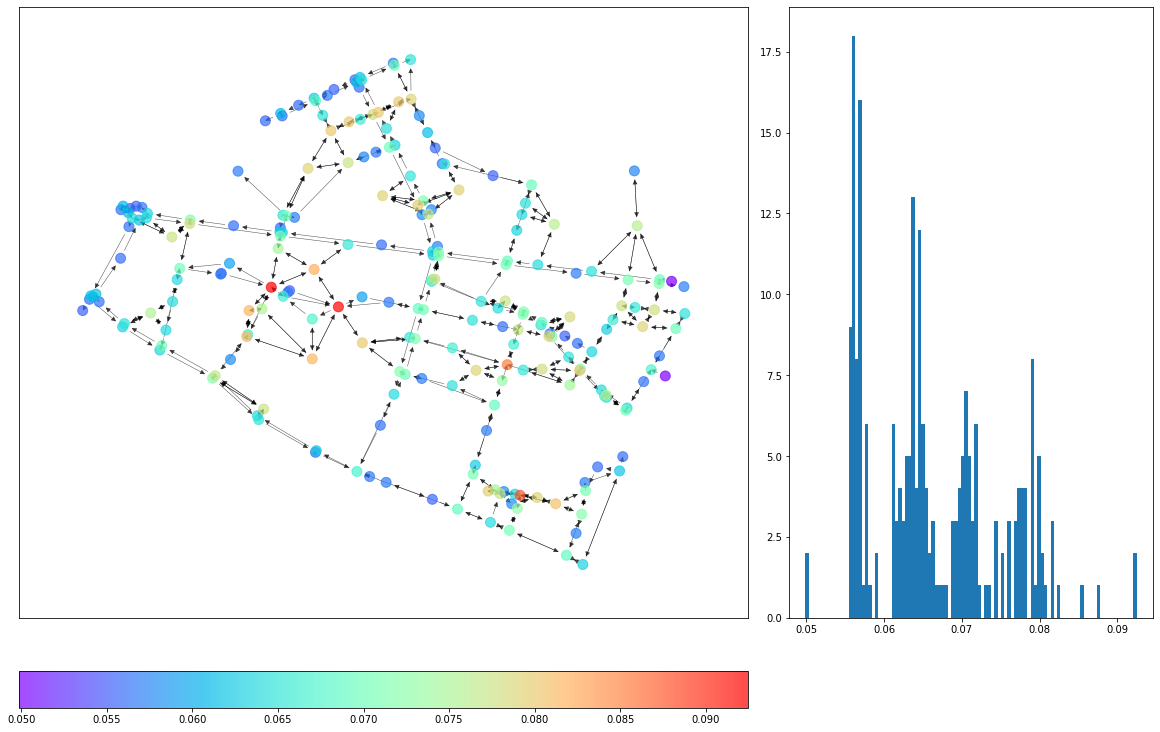

In [27]:
alpha = 0.1
katz_c = nx.katz_centrality(G, alpha)
plot_gragh(G, katz_c)

### 1.3.7 - Coreness centrality

A node $u$ has coreness $C_S(u)=k$ if $k$ is the largest value $k$-core containing that node. On the other hand, a $k$-core is a maximal subgraph that contains nodes of degree $k$ or more.

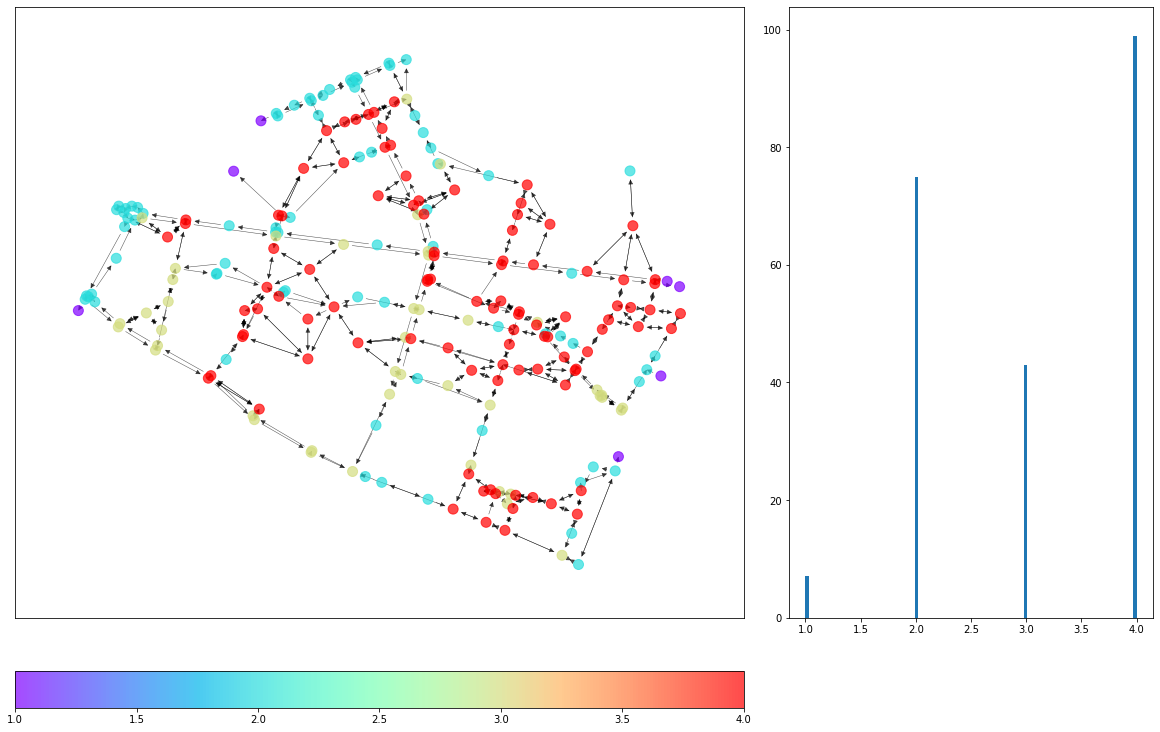

In [28]:
k_core = nx.core_number(G)
plot_gragh(G, k_core)

### 1.3.8 - Most central nodes

The all around score of a node can be computed as: $\sqrt{d^2 + C_B^2 + k_s^2}$, where $d$ is the degree, $C_B$ the betweenness centrality and $k_s$ the shell-index of the node.  The degree takes care of local connectivity of the node, betweenness takes care of shortest paths that represent global information, and k-shell represents the position of the node with respect to the center.

In [29]:
def all_around_score(degree, betwenness, shell):
    return np.sqrt(degree**2 + betwenness**2 + shell**2)

In [30]:
# Build df with all centraility measurements
centrality_df = pd.DataFrame.from_dict(dict(G.degree), orient='index', columns=['degree'])
centrality_df['betweenness'] = centrality_df.index.map(betweenness_c)
centrality_df['k_core'] = centrality_df.index.map(k_core)

In [31]:
centrality_df['node_id'] = centrality_df.index
centrality_df['score'] = centrality_df.apply(lambda x: all_around_score(x.degree, x.betweenness, x.k_core), axis=1)
centrality_df.sort_values(by=['score'], ascending=False, inplace=True)

centrality_df.head(10)

,degree,betweenness,k_core,node_id,score
201,12,0.077254,4,201,12.649347
190,11,0.169273,4,190,11.705924
127,10,0.142842,4,127,10.771277
99,10,0.046995,4,99,10.770432
159,9,0.113459,4,159,9.849511
184,8,0.132167,4,184,8.945248
20,8,0.120124,4,20,8.945079
17,8,0.114118,4,17,8.945000
21,8,0.103243,4,21,8.944868
194,8,0.088372,4,194,8.944708


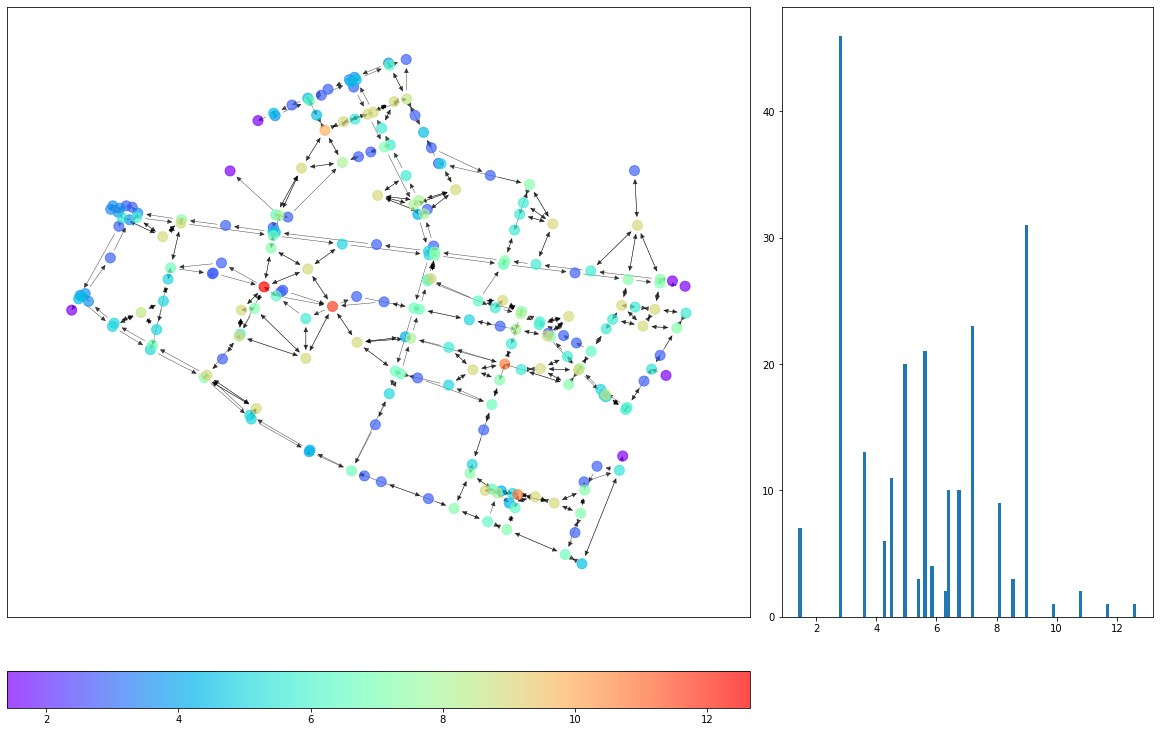

In [32]:
plot_gragh(G, dict(centrality_df['score']))

# 2 - Macroscale
## 2.1 - Model matching


### 2.1.1 - Erdos-Renyi

A random Erdos-Renyi graph can be constructed by specifying the number of nodes $N$ and the probability of every pair of nodes to be connected $p$. In our case, $N=224$, The expected number of links $L$ is a random variable with expectation value: $E(L)=pN(N-1)/2$. Since our links have a real-world meaning and we cannot add or remove streets easily, we will use the previous formula to compute the probability as:
$$
p=\frac{2E(L)}{N(N-1)}\, ,
$$

where for simplicity wi will consider $E(L)$ as the number of links that we have in the original network. An alternative could be to obtain the probability by fixing the mean connectivity.

In [33]:
p = (2*num_links)/(num_nodes*(num_nodes-1))
p

0.020940102498398463

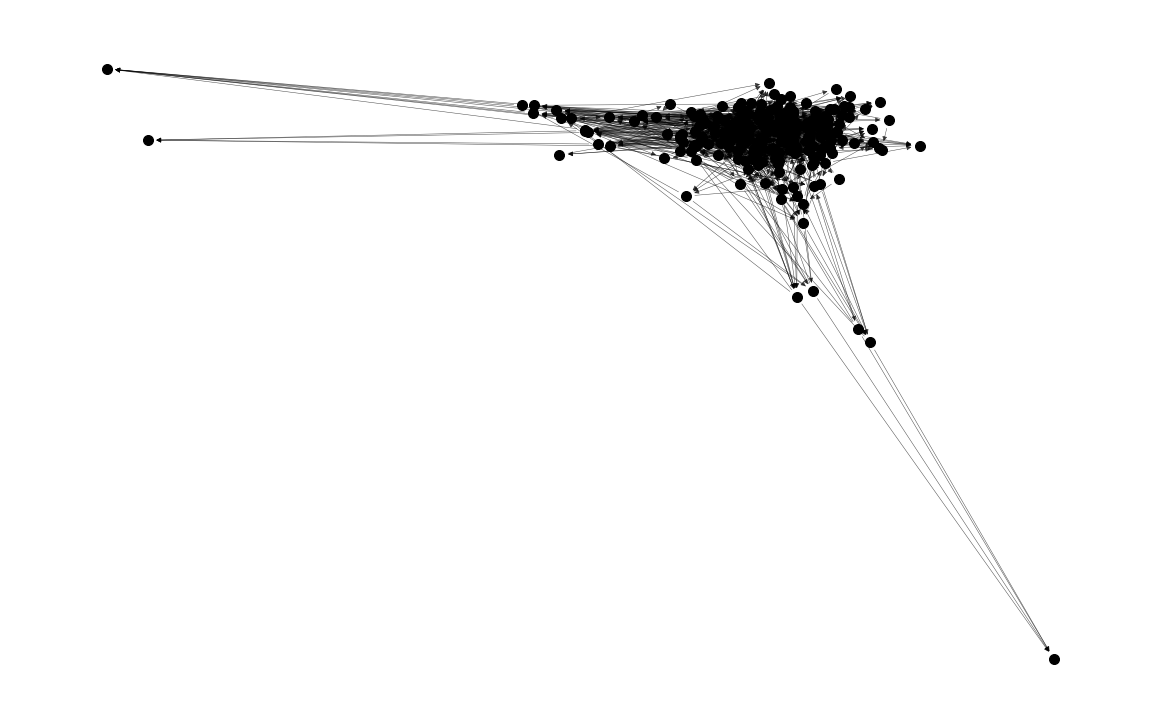

In [34]:
G_er = nx.erdos_renyi_graph(num_nodes, p=p, seed=0, directed=True)
plot_gragh(G_er, pos=None)

The mean connectivity for an Erdos-Renyi graph is given by $<k>=pN$, lets check if degree distributions coincide.

In [35]:
# Mean degree of original network
mean_degree_original = centrality_df.degree.mean()

# First lets validate the formula above
mean_degree_pn = p*num_nodes
mean_degree_computed = sum(dict(G_er.degree).values())/num_nodes

print(mean_degree_original)
print(mean_degree_pn)
print(mean_degree_computed)

4.669642857142857
4.690582959641256
9.366071428571429


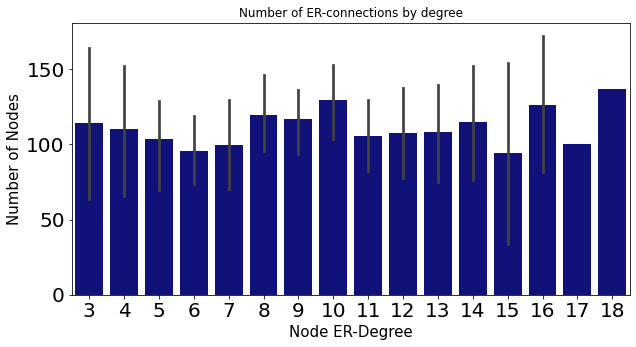

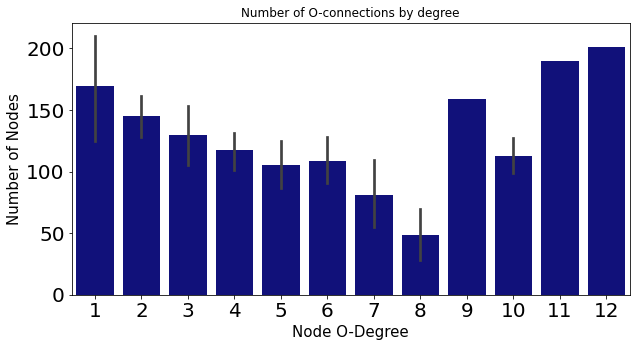

In [36]:
er_deg = dict(G_er.degree)
o_deg = dict(G.degree)

er_degree_hist = pd.DataFrame({"degree": list(er_deg.keys()), "Number of Nodes": list(er_deg.values())})
o_degree_hist = pd.DataFrame({"degree": list(o_deg.keys()), "Number of Nodes": list(o_deg.values())})

plot_grades(er_degree_hist, 'ER')
plot_grades(o_degree_hist, 'O')

Not matching. Furthermore we expect a scale free network, because although there are more nodes added (enlarging the city), intersecctions will almost always have the same number of connections. Below we test the formula for computing the mean short path: $l = \ln(N)/\ln(<k>)$

In [37]:
nx.average_shortest_path_length(G_er)

3.545063260730301

In [38]:
np.log(num_nodes)/np.log(mean_degree_computed)

2.419051987900776

## 2.1.2 - Watts-Strogatz

Altough this kind of graphs aren't directed, we will try to finde similarities. For creating a Watts-Strogatz graph we need to specify the number of nodes $N=224$, the connections to neighbors in ring topology $k$, and the probability of rewiring each edge $p$. We chose $k$ so it matches the mean node degree of the original network which is 4. This number is reasonable since most interesections are a crossing of two streets that usally originate and end in another intersection, suming a total of 4 neighbours. The value of $p$ has been set to $0.2$, small values are prone to produce regular lattices,, as one should expect from a city traffic network.

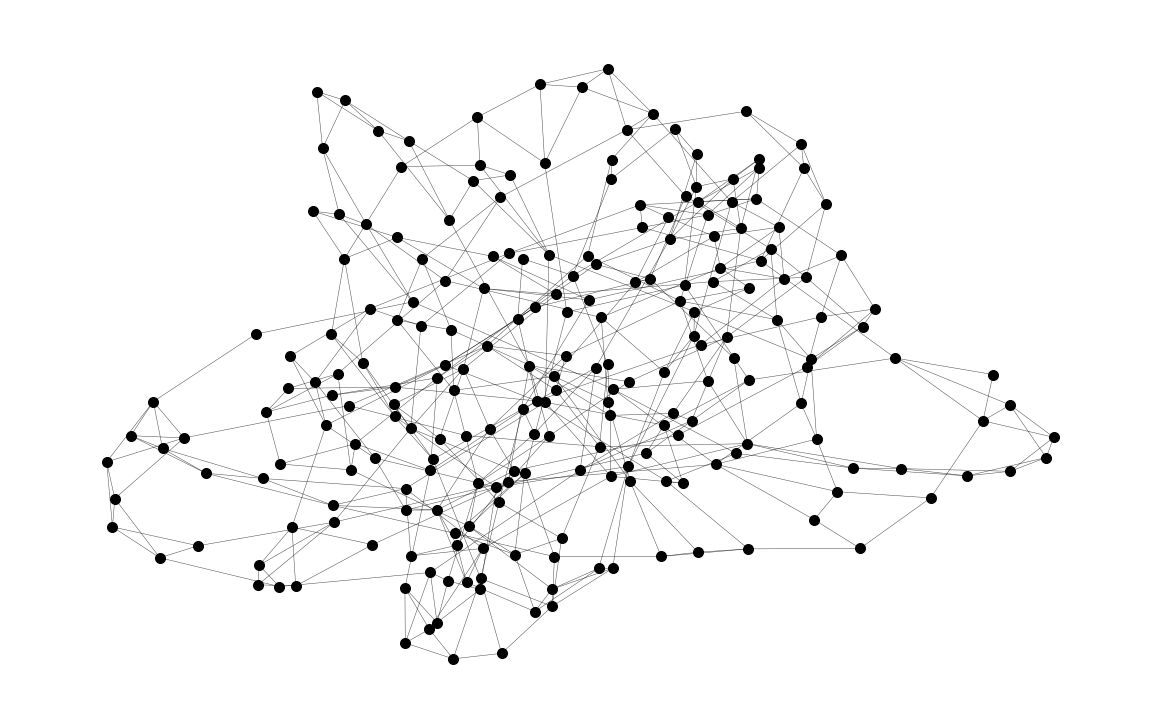

In [39]:
G_ws = nx.watts_strogatz_graph(num_nodes, k=int(mean_degree_original), p=0.2, seed=0)
plot_gragh(G_ws, pos=None)

In [40]:
# Compare degree dsitributions
mean_degree_computed = sum(dict(G_ws.degree).values())/num_nodes

print(mean_degree_original)
print(mean_degree_computed)

4.669642857142857
4.0


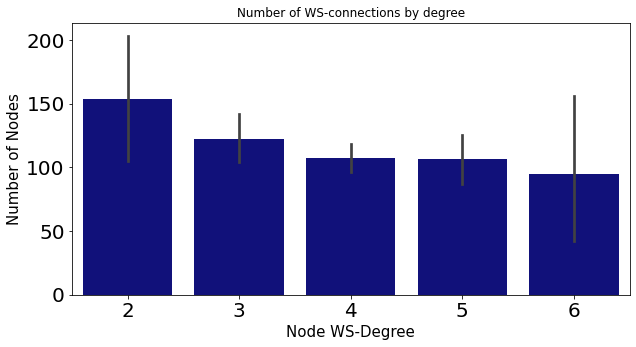

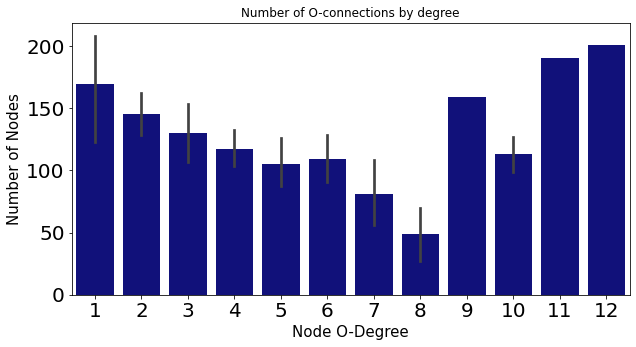

In [41]:
ws_deg = dict(G_ws.degree)
ws_degree_hist = pd.DataFrame({"degree": list(ws_deg.keys()), "Number of Nodes": list(ws_deg.values())})

plot_grades(ws_degree_hist, 'WS')
plot_grades(o_degree_hist, 'O')

In [42]:
nx.average_shortest_path_length(G_ws)

5.1084641255605385

### 2.1.3 - Barabasi-Albert

Again we will try to find similarities with an undirected type of graph, the Barabasi-Albert. We need to specify the number of nodes $N$, and $m$, the number of edges to attach from a new node to existing nodes, this number has been seed to 2.

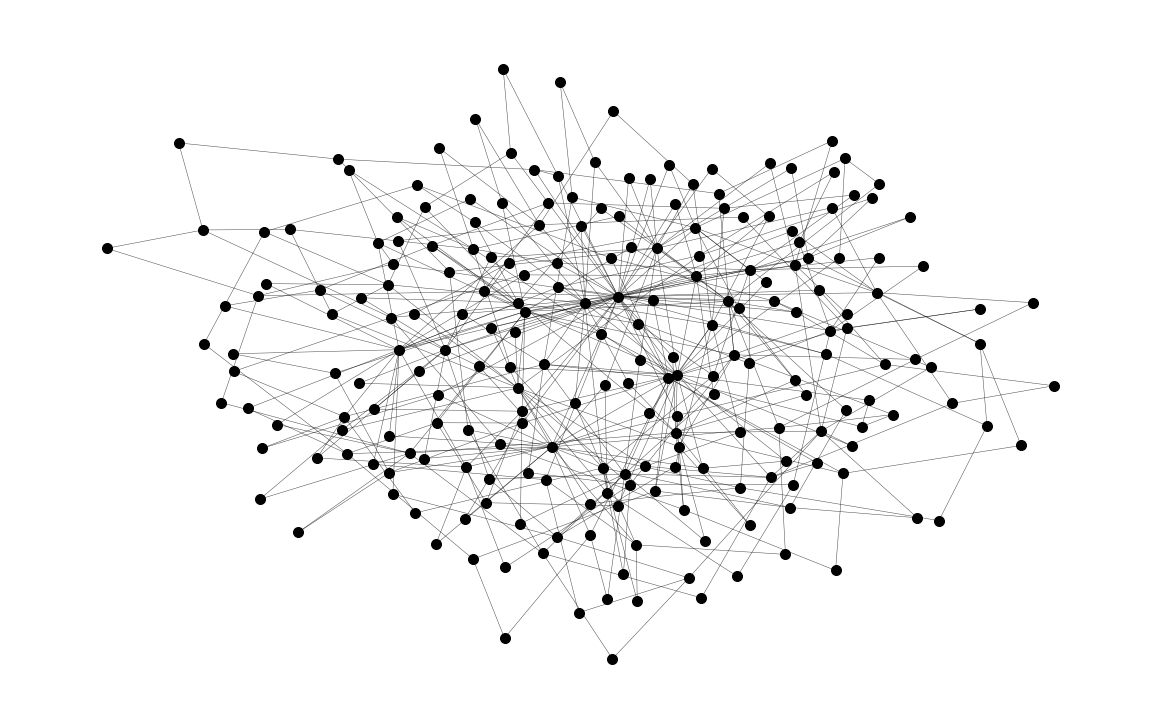

In [43]:
G_ba = nx.barabasi_albert_graph(num_nodes, m=2,seed=0)
plot_gragh(G_ba, pos=None)

In [44]:
# Compare degree dsitributions
mean_degree_computed = sum(dict(G_ba.degree).values())/num_nodes

print(mean_degree_original)
print(mean_degree_computed)

4.669642857142857
3.9642857142857144


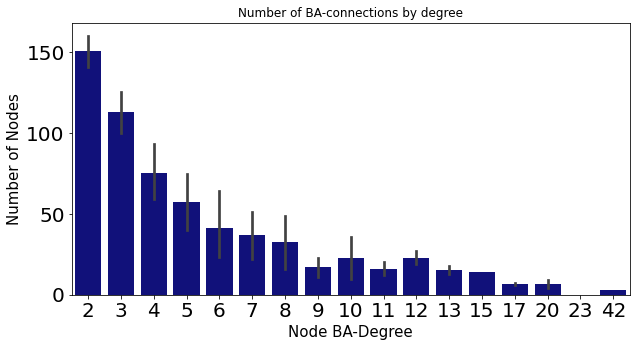

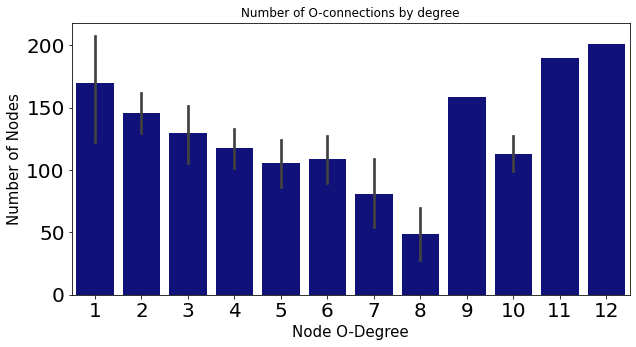

In [45]:
ba_deg = dict(G_ba.degree)
ba_degree_hist = pd.DataFrame({"degree": list(ba_deg.keys()), "Number of Nodes": list(ba_deg.values())})

plot_grades(ba_degree_hist, 'BA')
plot_grades(o_degree_hist, 'O')

Not realistic!

# 2.1.4 - Random Regular Graph

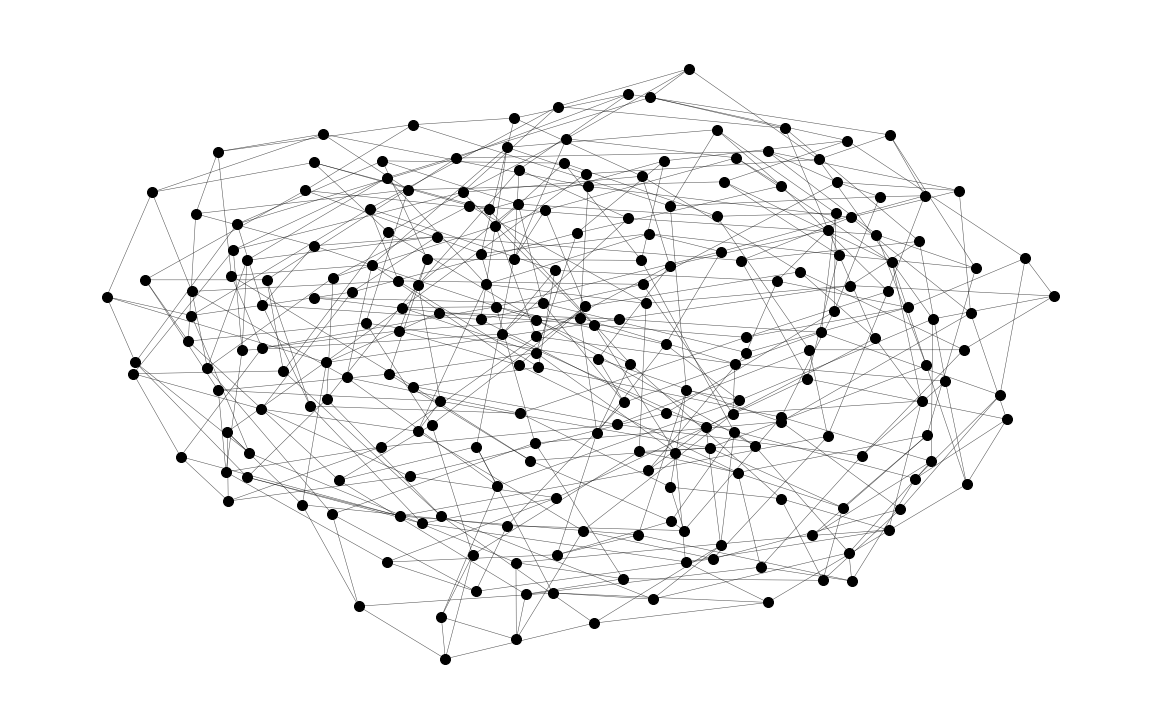

In [46]:
G_rr = nx.random_regular_graph(int(mean_degree_original),num_nodes)
plot_gragh(G_rr, pos=None)

# 3 - Mesoscale: finding communities

In [47]:
from networkx.algorithms import community

## 3.1 - Girvan_Newman Analysis

The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. The algorithm removes the “most valuable” edge, traditionally the edge with the highest betweenness centrality, at each step.


Top communities 2.


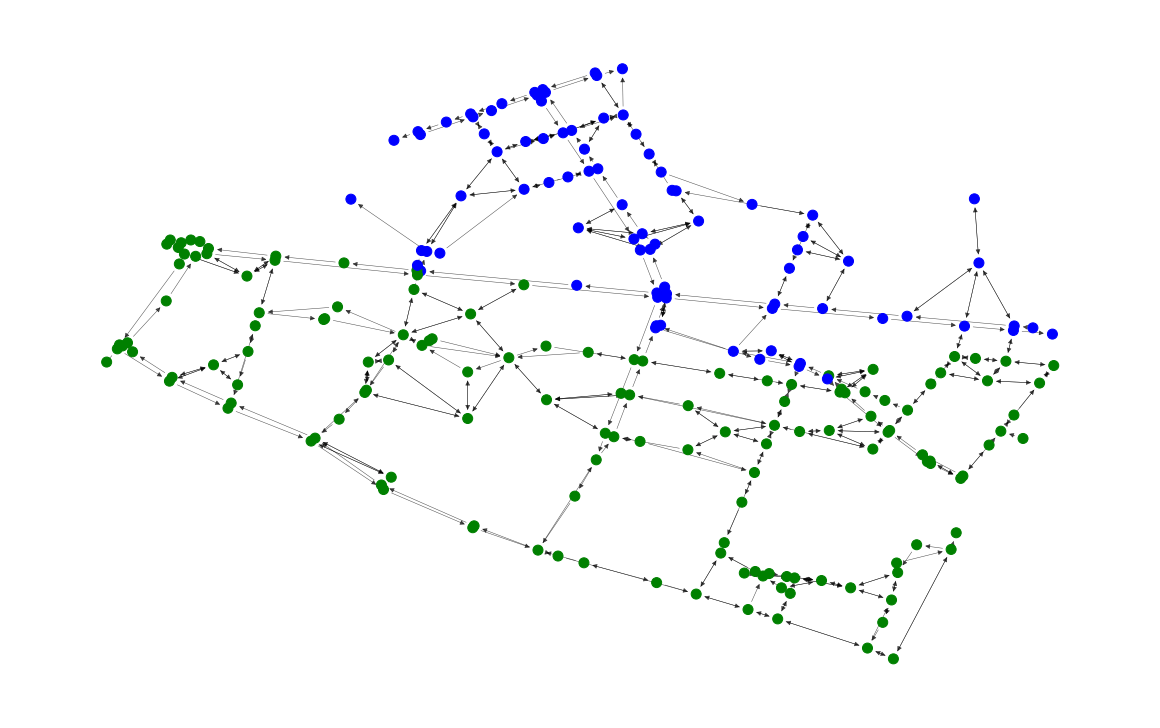

In [48]:
communities_generator = community.girvan_newman(G)
top_level_communities = next(communities_generator)
print(f"Top communities {len(top_level_communities)}.")

node_groups = []
for com in next(communities_generator):
    node_groups.append(list(com))

node_color = []
for node in G:
    if node in node_groups[0]:
        node_color.append('blue')
    else:
        node_color.append('green')
        
# nx.draw(G, node_color=node_color, with_labels=True)
plot_gragh(G, node_color=node_color)

These results are indeed consistent, but without much impact on smaller communities. Basically the neighbourhood is separated by the large diagonal that exists.

## 3.2 - Label Propagation algorithm

Label Propagation Algorithm is one of the semi-supervised machine learning algorithms that assigns labels to unlabeled data observations in order to partition classification of data observations within dataset. Within community network, the Label Propagation Algorithm is aimed to change label of each node based on community label of connected nodes of that node.

1. Each of the distinct nodes has its corresponding label
2. The corresponding label of each node denotes the distinct community that this node belongs to
3. Through iteration within the network, each node will update its belongingness community based on belongingness community of neighbor nodes until all of the nodes with the same label are attributed to same communities
4. The updated community of each node will be the corresponding belongingness community of the maximum number of nodes
5. Eventually, densely connected nodes reach a common label community


The Berlin traffic network has 40 communities.


/var/folders/2c/gnzzbzv56sxdqjpm4jd2152m0000gn/T/ipykernel_8899/978834352.py:6: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  csr_graph = nx.adjacency_matrix(G)


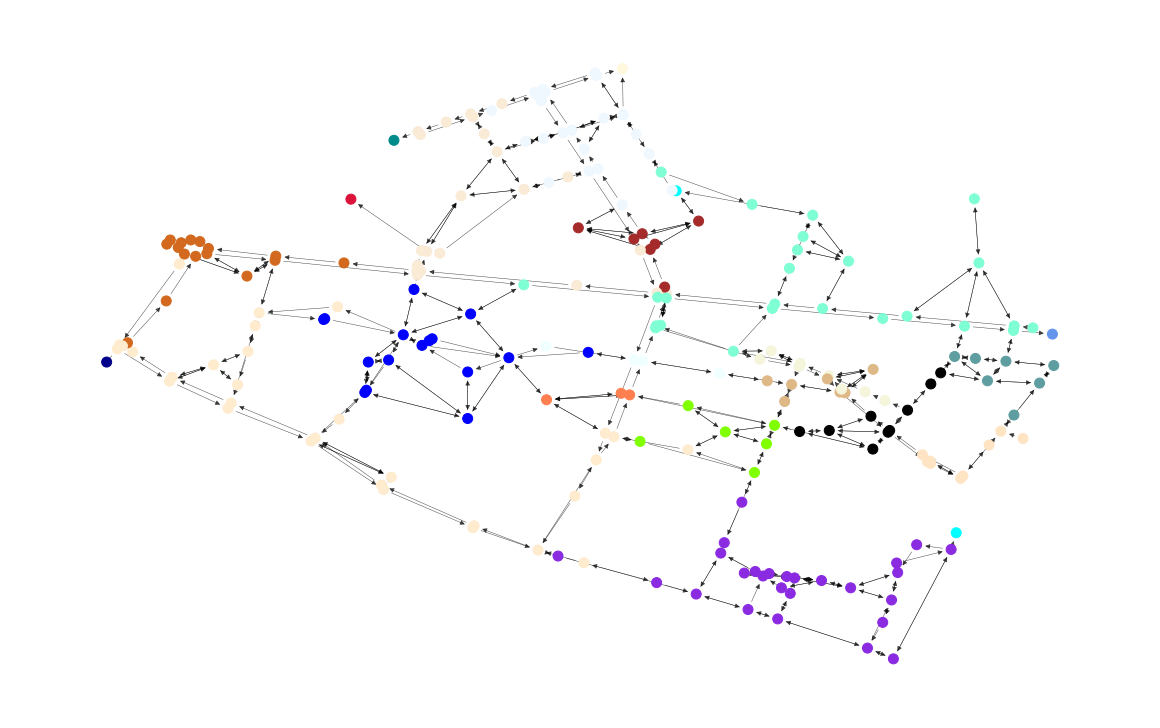

In [49]:
communities_generator = community.asyn_lpa_communities(G,weight="weight")
result = {frozenset(c) for c in communities_generator}
print(f"The Berlin traffic network has {len(result)} communities.")

from sknetwork.clustering import PropagationClustering
csr_graph = nx.adjacency_matrix(G)
position = np.array([[coords.loc[node]['x'], coords.loc[node]['y']] for node in coords.index])
propagation = PropagationClustering()
labels = propagation.fit_transform(csr_graph)

from matplotlib import colors as mcolors
colors = list(mcolors.CSS4_COLORS)

# get a list of colors from labels list 
colors_list = [] 
for i in labels:
    colors_list.append(colors[i])
plot_gragh(G, node_color=colors_list)


This algorithm is somewhat stochastic so, we can find different communities of each execution. Although we have a larger number of communities. We can more or less see the different areas that make up the neighbourhood.

## 3.3 - Greedy Modularity

Greedy algorithm maximizes modularity at each step:
1. At the beginning, each node belongs to a different community;
2. The pair of nodes/communities that, joined, increase modularity the most, become part of the same community. Modularity is calculated for the full network
3. Step 2 is executed until one community remains;
4. Network partition with the higher modularity is chosen.


The Berlin traffic network has 12 communities.


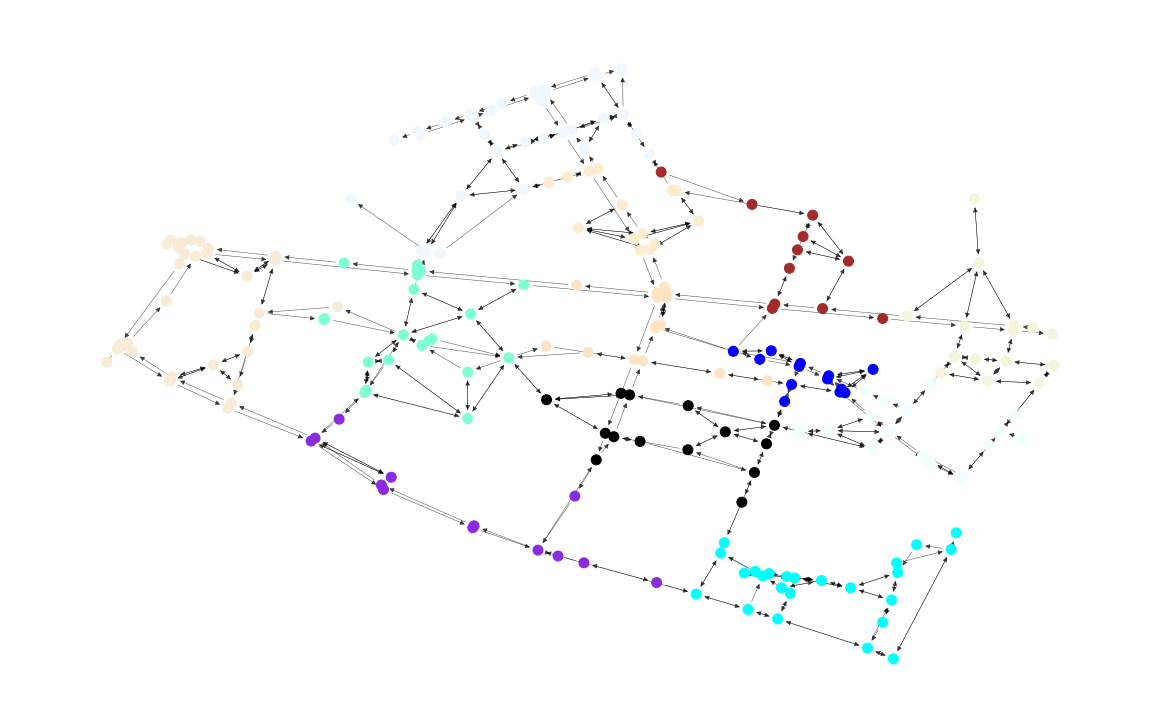

In [50]:
# Find the communities
communities_greedy = community.greedy_modularity_communities(G)
communities_list = sorted(community.greedy_modularity_communities(G), key=len, reverse=True)
# Count the communities
print(f"The Berlin traffic network has {len(communities_list)} communities.")

# assign color with matplotlib mapping for 12 communities
node_color = []
for node in G:
    for i in range(len(communities_list)):
        if node in communities_list[i]:
            node_color.append(colors[i])

plot_gragh(G, node_color=node_color)

We can see similar communities that the last algorithm, but in this case we obtain always 12 communities and it is clear to see.

## 3.4 - Louvain Communities
Louvain is an unsupervised algorithm (does not require the input of the number of communities nor their sizes before execution) divided in 2 phases: 
1. Modularity Optimization. Louvain will randomly order all nodes in the network in Modularity Optimization. Then, one by one, it will remove and insert each node in a different community 𝐶 until no significant increase in modularity (input parameter) is verified

2. Community Aggregation. After finishing the first step, all nodes belonging to the same community are merged into a single giant node. Links connecting giant nodes are the sum of the ones previously connecting nodes from the same different communities. This step also generates self-loops which are the sum of all links inside a given community, before being collapsed into one node

#### 3.4.1 - Louvain Communities undirected



<IPython.core.display.Javascript object>


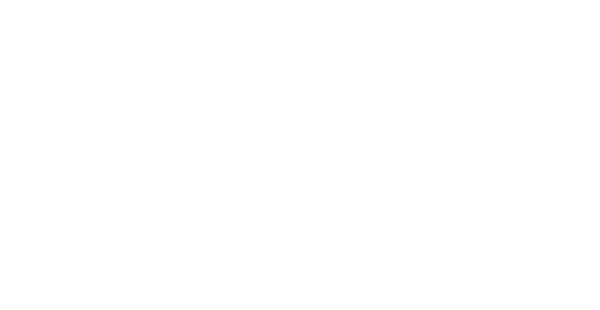

In [51]:
# community_louvain = community.louvain_communities(G, seed=123)
%matplotlib notebook

from communities.algorithms import louvain_method
from communities.visualization import draw_communities, louvain_animation
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

# from communities.visualization import louvain_animation


communities, frames = louvain_method(adj_nx)
# draw_communities(adj_nx, communities)
louvain_animation(adj_nx, frames, duration=5)

#### 3.4.2 - Louvain Communities directed and position

/var/folders/2c/gnzzbzv56sxdqjpm4jd2152m0000gn/T/ipykernel_8899/871587923.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  csr_graph = nx.adjacency_matrix(G)


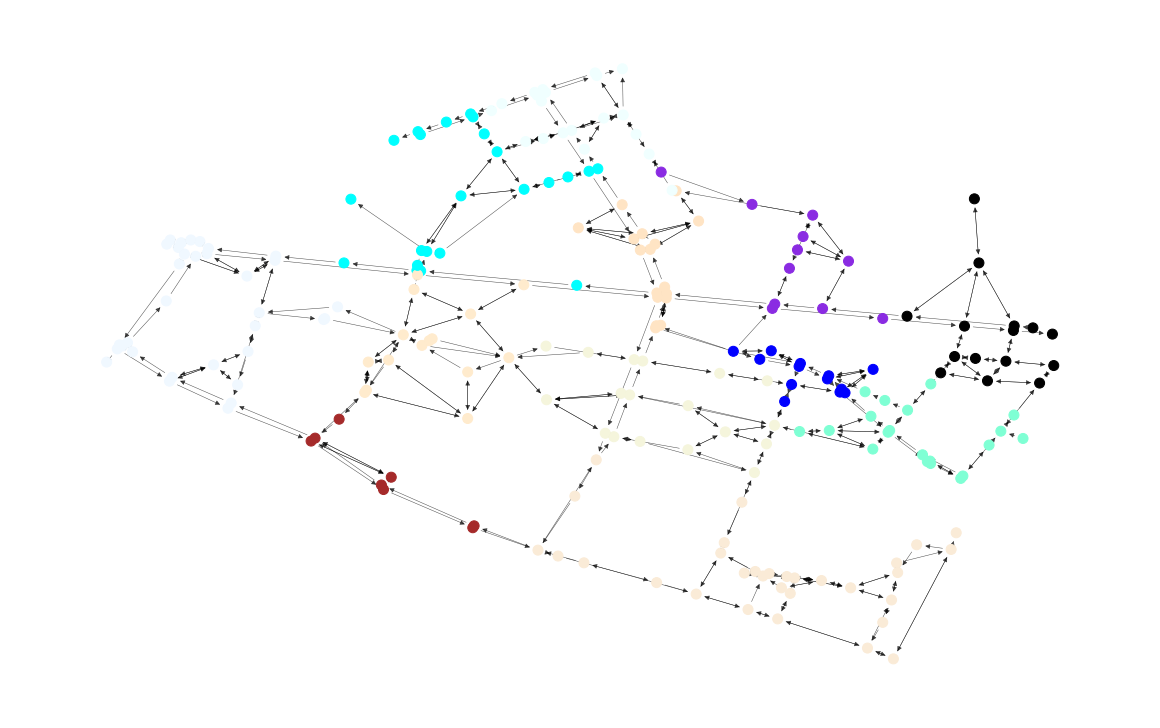

The Berlin traffic network has 12 communities.


In [52]:
from sknetwork.clustering import Louvain
from IPython.display import SVG
%matplotlib inline
louvain = Louvain()
csr_graph = nx.adjacency_matrix(G)
labels = louvain.fit_transform(csr_graph)
position = np.array([[coords.loc[node]['x'], coords.loc[node]['y']] for node in coords.index])
from matplotlib import colors as mcolors
colors = list(mcolors.CSS4_COLORS)

# get a list of colors from labels list 
colors_list = [] 
for i in labels:
    colors_list.append(colors[i])
plot_gragh(G, node_color=colors_list)
labels_unique, counts = np.unique(labels, return_counts=True)
print(f"The Berlin traffic network has {len(labels_unique)} communities.")

The result is very similar than Greedy's algorithm modularity, with 12 communities.

## 4 - Dynamics: Traffic flow
The goal is to simulate the traffic flow in the neighborhood of Friedrichshain. In order to do so we will consider the difussion equation:

$$
\frac{\partial \phi(\mathbf{r},t)}{\partial t} = \alpha\nabla^2\phi(\mathbf{r},t)\, .
$$

Each node in the network represents a local site where some "charge" can be accumulated, and each directed edge represents a channel through which the stuff can be transported in the correspondent way, driven by the gradient of its concentration. If we represent the nodes states by a state vector $\mathbf{c}(t)$, the previous equation can be written as:
$$
\frac{d\mathbf{c}(t)}{dt} = - \alpha L \mathbf{c}(t)\, ,
$$

where $L$ is the Laplacian matrix of the network and $\alpha$ the diffusion coefficient. Since we are studying the spread of the traffic along the streets, we will use the out-degree Laplacian, computed as: 
$$
L_{out}=D_{out}-A\, , 
$$
where $A$ is the adjancency matrix and $D_{out}$ is a diagonal matrix with the out-degree of the nodes. By discretizing the time derivative:

$$
\mathbf{c}^{t+1} = \left(I-\alpha L\Delta t\right)\mathbf{c}^{t}\, .
$$

We set as intial conditions a high value of traffic in the sources of the graph:

$$
\mathbf{c}^{0}=\begin{cases}
100\quad \text{if node is a source,}\newline
0\quad \text{if node is a sink,}\newline
10\quad \text{otherwise.}
\end{cases}
$$

Regarding the boundary conditions, we will consider that sink nodes have null traffic at any time (dissipate the energy):
$$
\forall t, \quad\mathbf{c}^{t}=\begin{cases}
c_i^t \quad \text{if node $i$ is not a sink,}\newline
0 \quad \text{otherwise.}
\end{cases}
$$

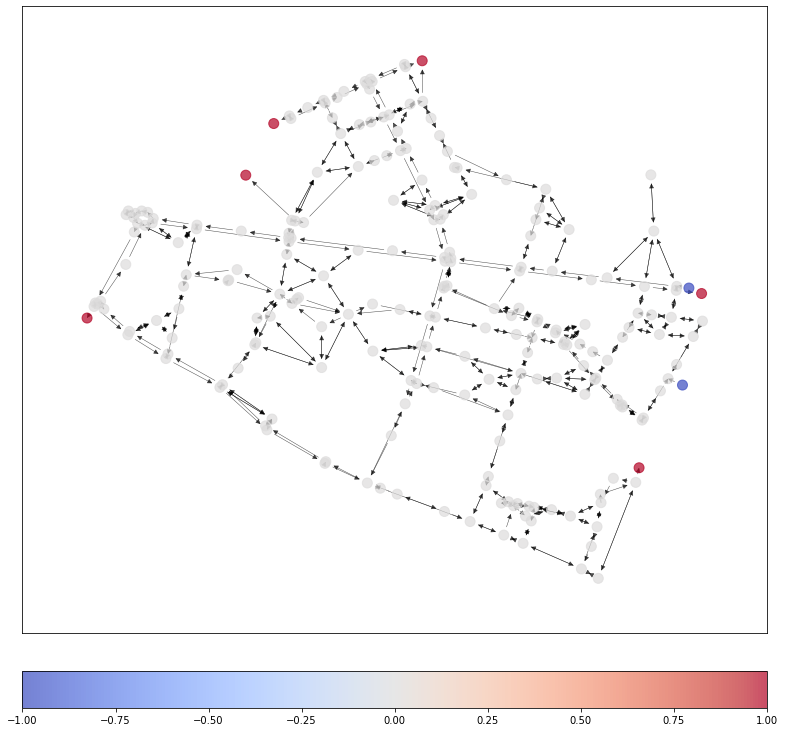

In [53]:
# PLOT SOURCES AND SINKS
sink_nodes = [node for node, outdegree in G.out_degree(G.nodes()) if outdegree == 0]
source_nodes = [node for node, indegree in G.in_degree(G.nodes()) if indegree == 0]

G_in_out = {}
for node in G.nodes():
    if node in sink_nodes:
        G_in_out[node] = 1  # red
    elif node in source_nodes:
        G_in_out[node] = -1  # blue
    else:
        G_in_out[node] = 0
        
plot_gragh(G, G_in_out, cmap='coolwarm', hist=False)

In [54]:
# INITIALIZE SCORES IN SOURCES
g_states = {}

for node in G.nodes():
    if node in source_nodes:
        g_states[node] = 100
    elif node in sink_nodes:
        g_states[node] = 0
    else:
        g_states[node] = 10

In [55]:
# CONSTANTS
#alpha = 20  # diffusion cte
#dt = 1e-2  # time intervals
a = 0.05 #dt*alpha


# COMPUTE THE LAPLACIAN
A = nx.adjacency_matrix(G)
D_out = np.zeros((num_nodes,num_nodes))

for key, value in dict(G.out_degree()).items():
    D_out[key-1,key-1]=value
    
L = D_out - A


# UPDATE MATRIX
update_mat = (np.eye(num_nodes)-a*L)


# INITIALIZE FRAME STORAGE MATRIX
num_frames = 120
ordered_states = collections.OrderedDict(sorted(g_states.items()))
S = np.zeros((num_frames,num_nodes))
S[0,:] = np.array(list(ordered_states.values()))

/var/folders/2c/gnzzbzv56sxdqjpm4jd2152m0000gn/T/ipykernel_8899/652632641.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


In [56]:
# SIMULATE 
for i in range(num_frames-1):
    initial_state = S[i,:]
    new_state = np.matmul(update_mat, initial_state)
    new_state[:,np.array(sink_nodes)-1]=0 #dissipate
    S[i+1,:] = new_state

(-0.23122470000000003, 2.4333647000000003, -0.22169909999999998, 2.3331191)

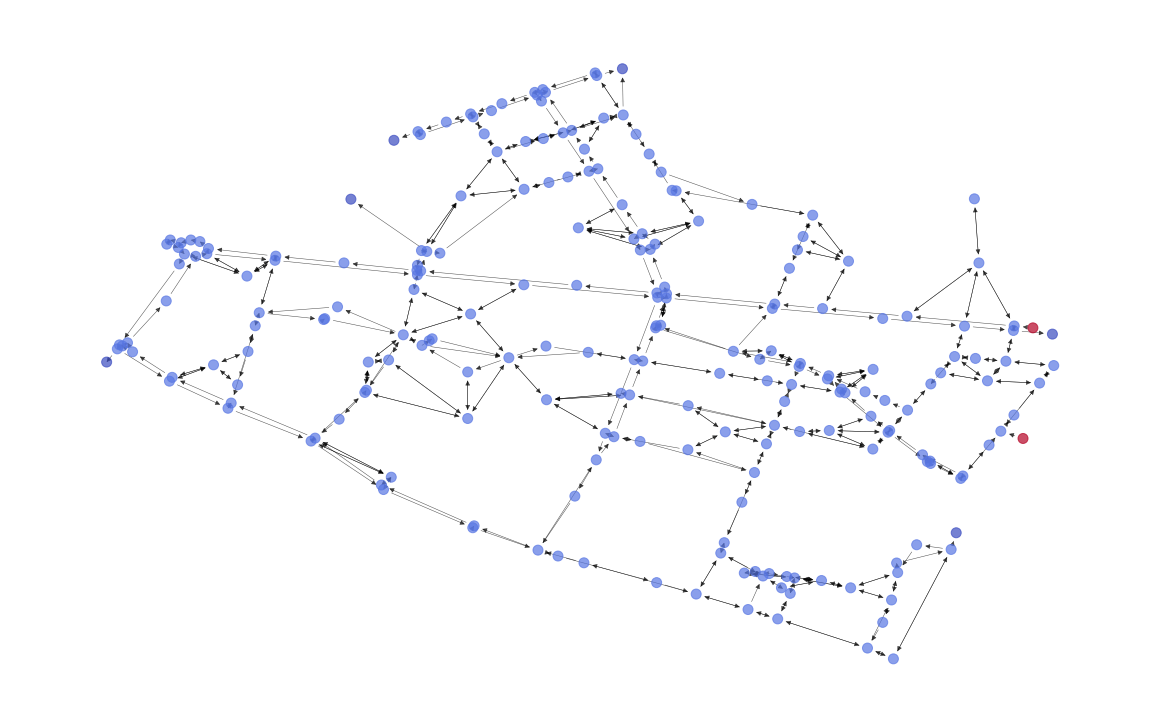

In [57]:
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
nodes = nx.draw_networkx_nodes(G, pos=coords_dict, node_size=100, alpha=0.7, node_color=S[0,:], cmap='coolwarm')
edges = nx.draw_networkx_edges(G,pos=coords_dict, width=0.5, alpha=0.7)
plt.axis('off')

order = np.array(G.nodes())-1

def init():
    scores = S[0,:]
    ncolor = np.array([scores[i] for i in order])
    nodes.set_array(ncolor)
    return (nodes,)

# animation function. This is called sequentially
def animate(i):
    scores = S[i,:]
    ncolor = np.array([scores[j] for j in order])
    nodes.set_array(ncolor)
    return (nodes,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=num_frames, interval=100)

HTML(anim.to_html5_video())

In [ ]:
anim.save('simulated_flow.gif', writer='imagemagick',  savefig_kwargs={'facecolor':'white'}, fps=150)

MovieWriter imagemagick unavailable; using Pillow instead.
